In [1]:
import utils
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from astropy.io import ascii
from scipy import optimize
from matplotlib import mlab

In [2]:
df_data = utils.read_data("datasets/time-curves/2301590/")

In [3]:
df = df_data[['TIME','SAP_FLUX','PDCSAP_FLUX','SAP_FLUX_ERR','PDCSAP_FLUX_ERR','CADENCENO']].dropna()

In [9]:
col = ['SAP_FLUX','PDCSAP_FLUX']
ecol = ['SAP_FLUX_ERR','PDCSAP_FLUX_ERR']
col2 = ['F','FPDC']   # Names for the modified columns.
ecol2 = ['EF','EFPDC']

In [10]:
r = copy.deepcopy(df)

In [11]:
for c,ec,c2,ec2 in zip(col,ecol,col2,ecol2):
    medf = np.median(r[c])
    norm = r[c] / medf - 1
    enorm = r[ec] / medf
    r[c2] = norm
    r[ec2] = enorm

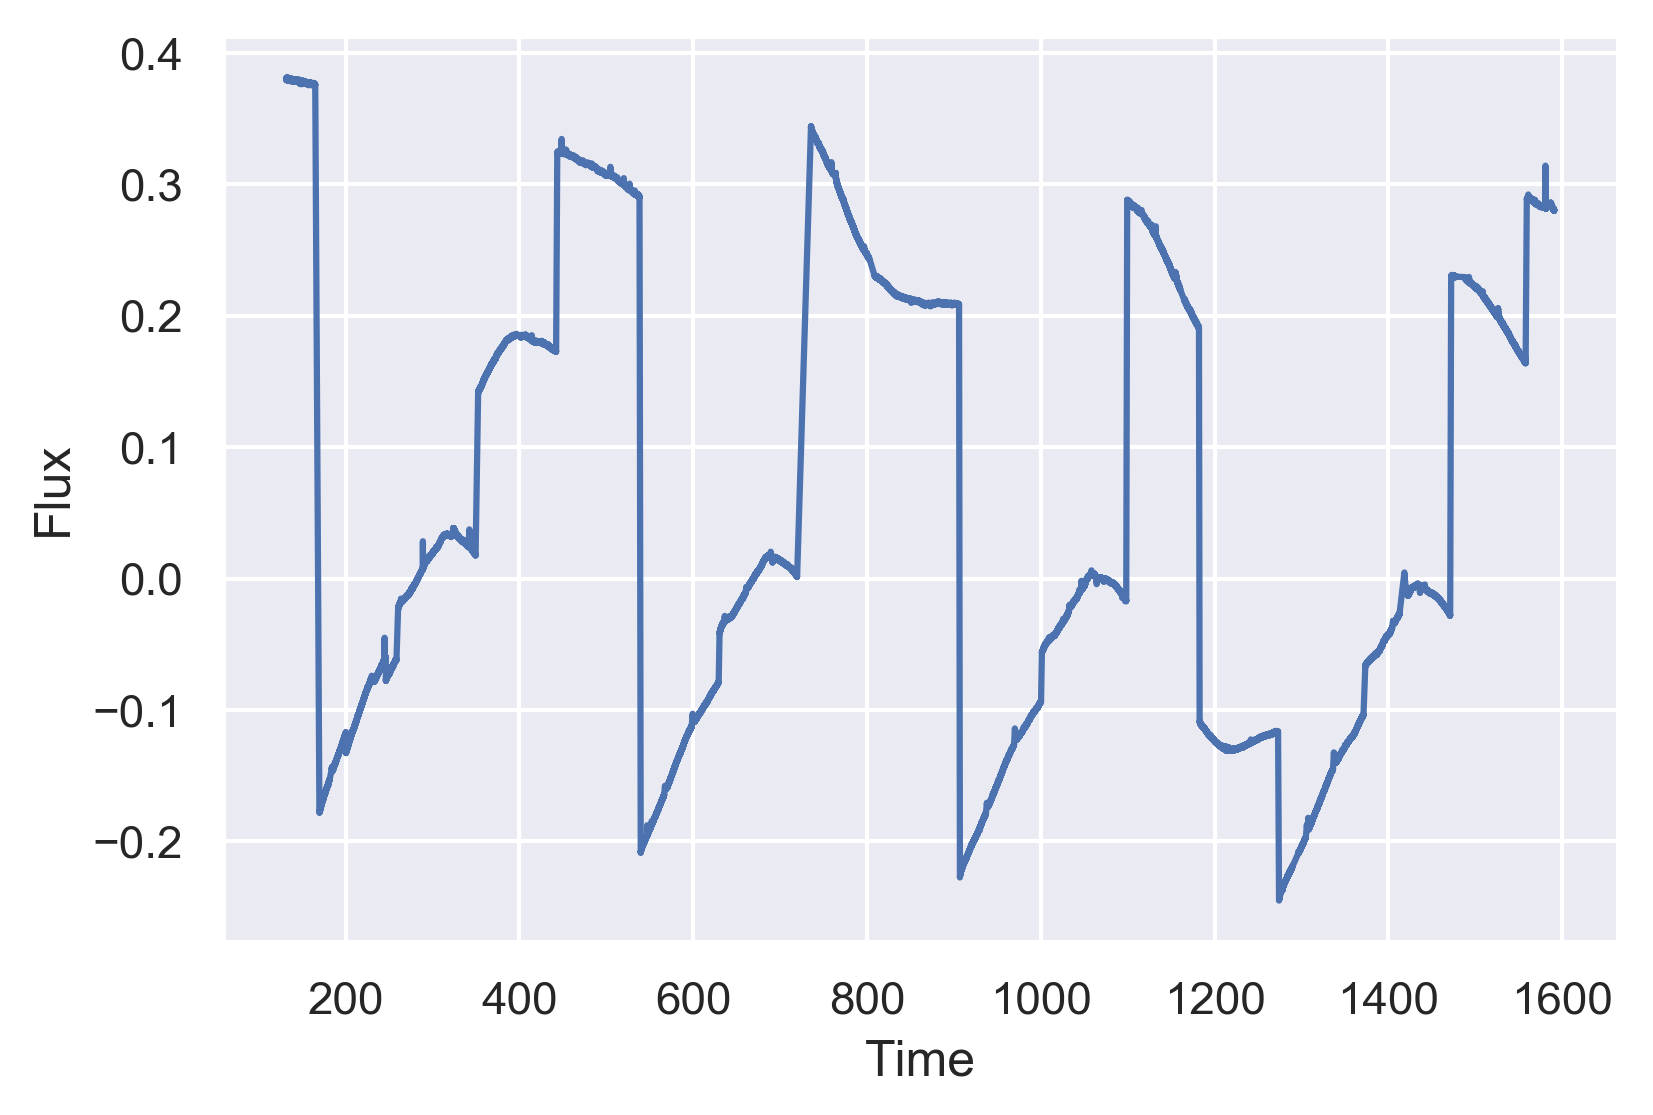

In [13]:
utils.plot_data(r.TIME,r.F)

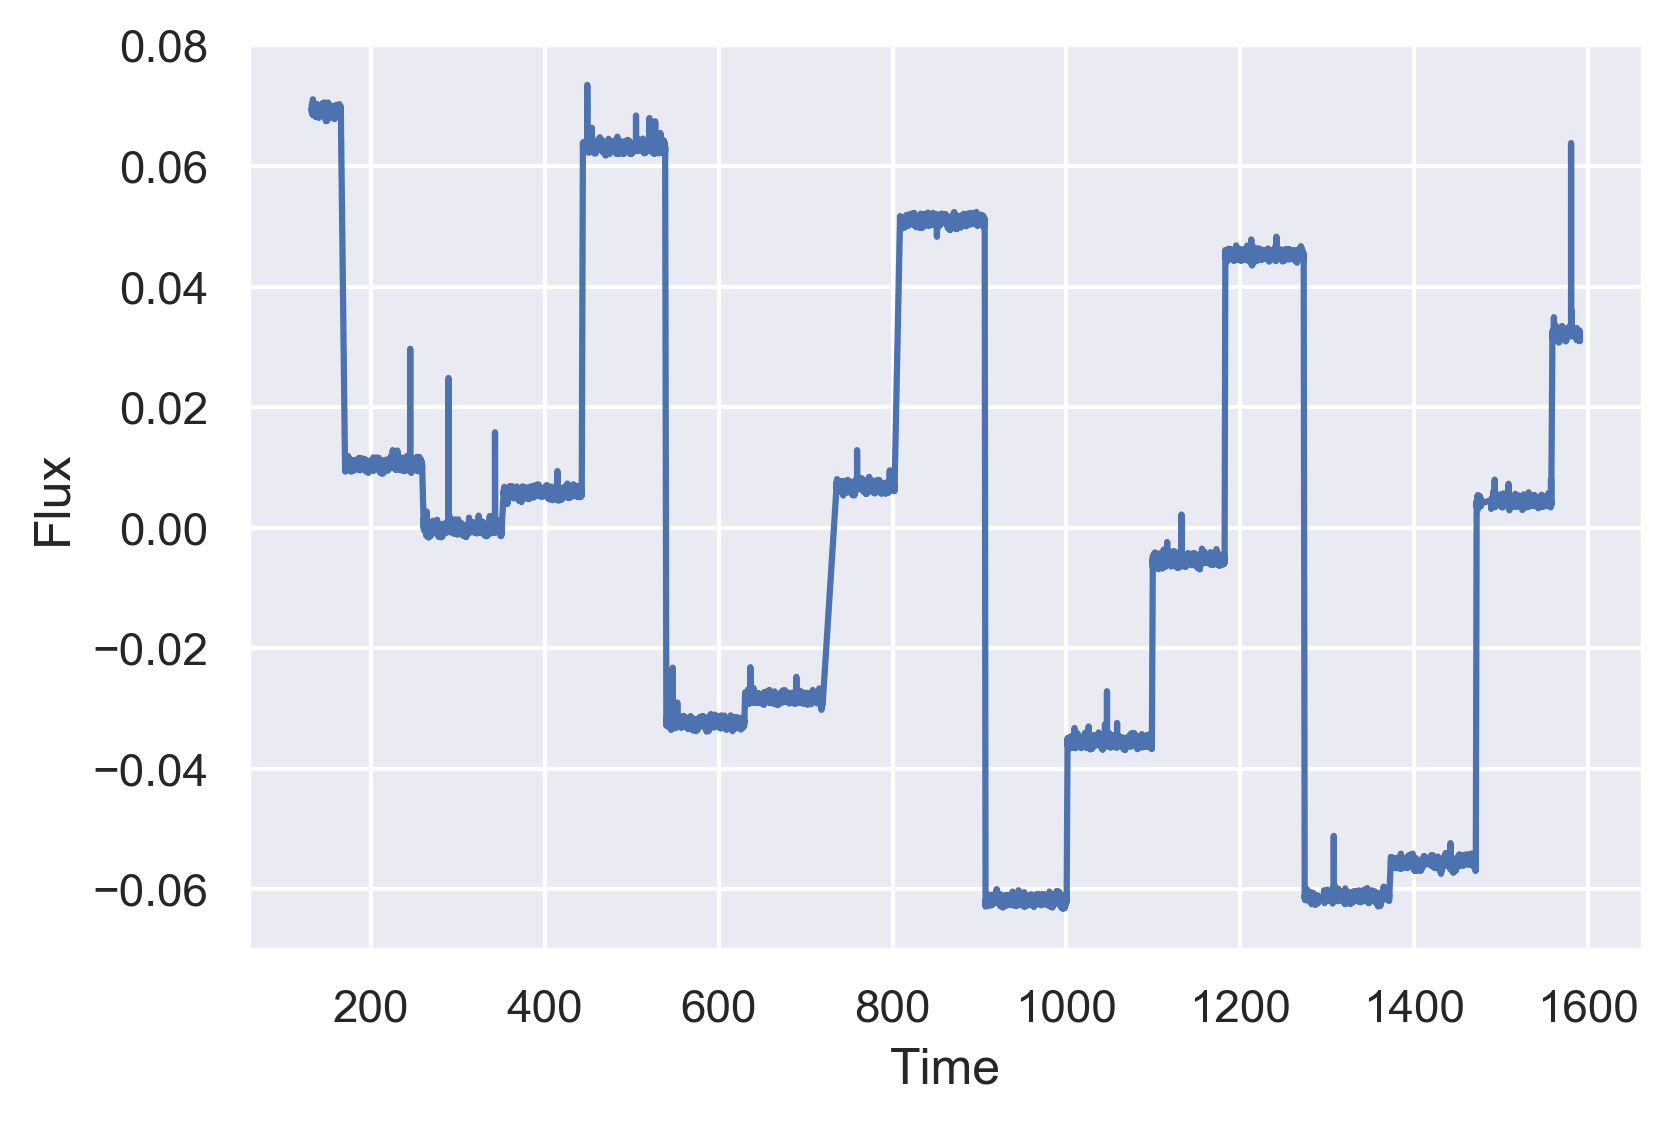

In [14]:
utils.plot_data(r.TIME,r.FPDC)

In [38]:
utils.remove_noise(r, r.F)

In [39]:
r = r.dropna()

In [40]:
tt = r.TIME
yy = r.MEDIAN
res = utils.fit_sin(tt,yy)

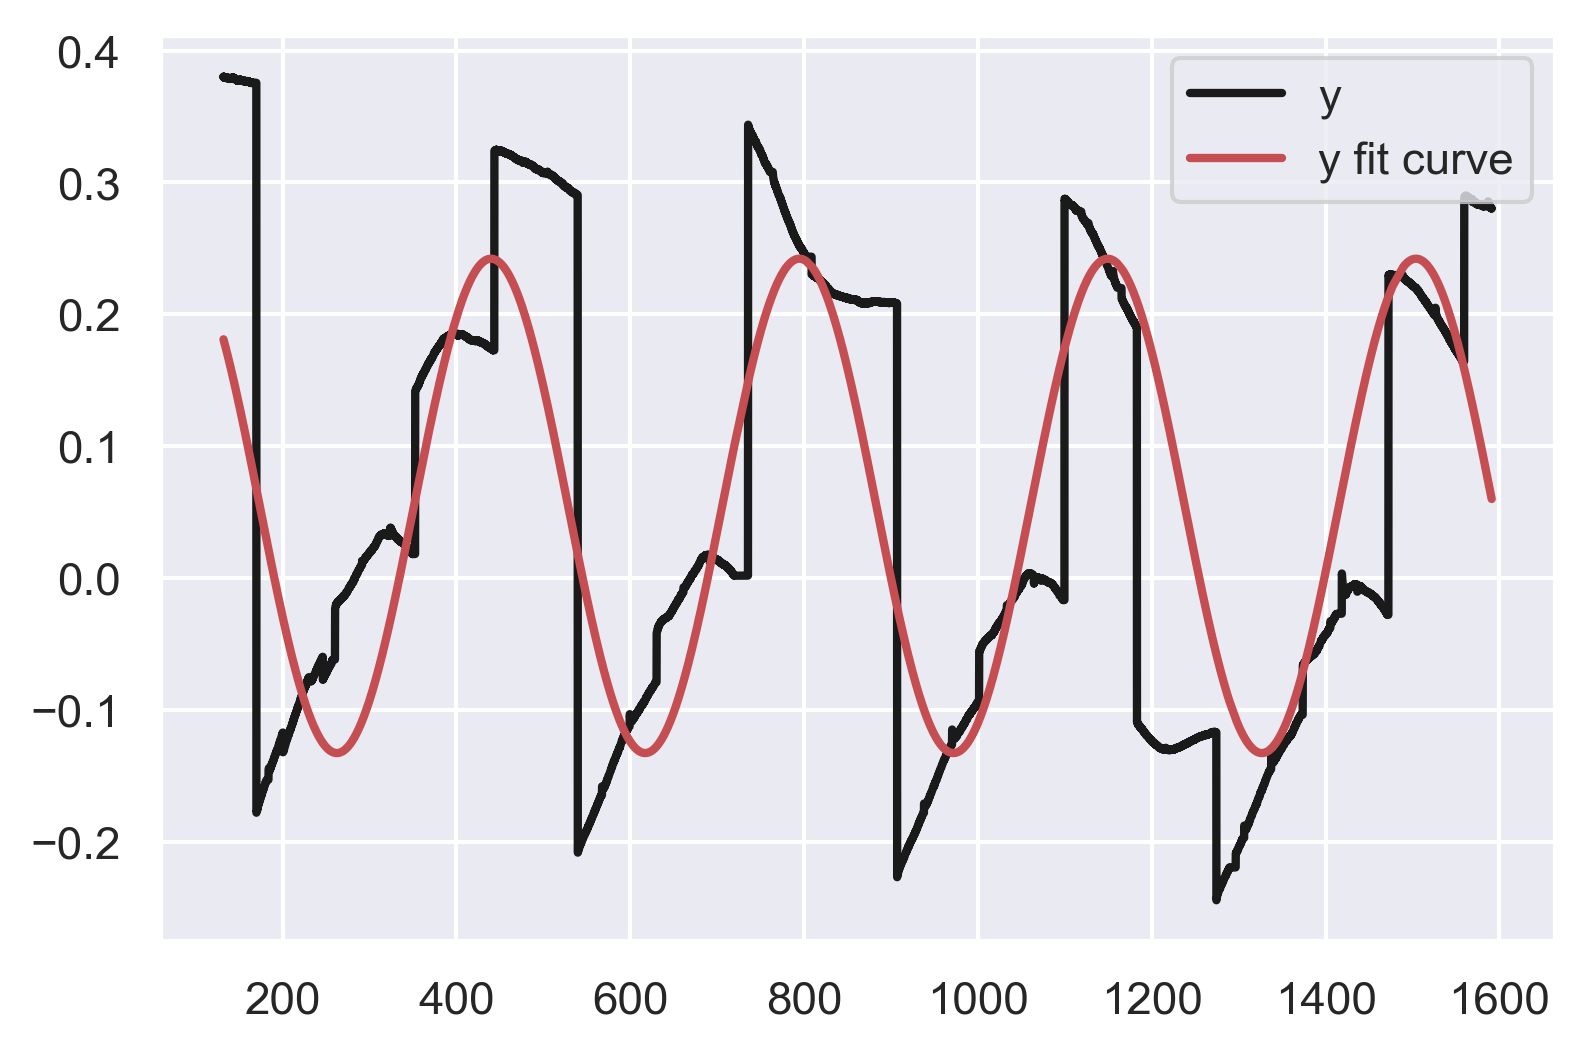

In [41]:
plt.figure(1,dpi=300)
plt.plot(tt, yy, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.show()

In [42]:
res['period']

354.69290839642287